<a href="https://colab.research.google.com/github/Ettaher471/Classification-machine-learning-disease-/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project <img align='right' width='120' height='130' src='https://maiseducativa.com/wp-content/uploads/2015/02/Logo_Nova-IMS.jpg'>
<p>
<p>    
    

>> __Daniel Franco, nº20210719__ , m20210719@novaims.unl.pt<p>
>> __Taher Ben Slama, nº20221039__ ,20221039@novaims.unl.pt<p>
    
***

### 💾 Data

All jupyter notebooks will be in the same folder with the data already downloaded.
Directory structure:

    1. Main folder contains 1 subfolder & a CSV file:
        1.1 Train
        1.2 train_data.csv

The annotated dataset of poultry disease diagnostics for small to medium-scale poultry farmers consists of poultry fecal images. The poultry fecal images were taken in Arusha and Kilimanjaro regions in Tanzania between September 2020 and February 2021 using Open Data Kit (ODK) app on mobile phones. The classes are "Coccidiosis" ,"Healthy", "New Castle Disease" ,"Salmonella". The images are already resized to 224px by 224px.

__Source:__ https://www.kaggle.com/datasets/allandclive/chicken-disease-1
    
<br>

---

<br>


### 📖 Introduction

Within the scope of __Deep Learning__, it was proposed a project, where the student's ability to __build an Image Classification model__ following a specific challenge would be tested. It was proposed to create a __sequencial model in a greedy iterative manner__ so that the students would be able to test several parameters and analyze their impact on the models. The project __will be divided into 5 notebooks__:

> 1. __Exploration__ - Data Exploration & Analysis <br>
>
> 2. __Preprocessing__ - Data Preprocessing <br>
>
> 3. __Model Handcrafted__ - Sequential Modle construction in a greedy iterative manner<br>
>
> 4. __Models Hyper Search__ - Hyperparameter Search & comparison with Handcrafted Model <br>
>
> 5. __Transfer Learning__ - Tranfer Learning of pre-trained models & comparison with Best Model <br>
>
<br>

---

### 📈 The Challenge

 By leveraging a collection of poultry fecal images, captured using the Open Data Kit (ODK) app on mobile phones, we aim to __enhance disease identification and classification__.

 These images were gathered in the Arusha and Kilimanjaro regions of Tanzania, spanning a period from September 2020 to February 2021. The dataset encompasses four distinct classes: __"Coccidiosis," "Healthy," "New Castle Disease," and "Salmonella"__ reflecting the common diseases affecting poultry.

All images are already resized to a standardized resolution of 224px by 224px. We can undertake the task of __multi-class image classificatio__, equipping poultry farmers with a valuable tool to swiftly identify and address diseases that impact their flocks.

By harnessing the power of data-driven diagnostics, we can significantly improve the overall health and well-being of poultry farms, ultimately contributing to the sustainable growth of the poultry industry.

__NOTE: TO DOWNLOAD THE DATA YOU NEED THE KAGGLE API TOKEN FILE  (`kaggle.json`) IN YOUR CURRENT DIRECTORY__

<br>

---

## <center> __Chicken Disease Image Classification__ </center>    

## <font color='lightblue'>__Transfer Learning__</font><br>

## References
1. [ResNet, K. He et al. (2016)](https://arxiv.org/pdf/1512.03385.pdf)
2. [EfficientNetB1](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB1)
3. [The Functional API, official documentation](https://www.tensorflow.org/guide/keras/functional)
4. [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)
4. [Deep Convolutional Neural Network for Chicken Diseases Detection,by Dina Machuve](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)


### Dependencies

In [ ]:
# install
!pip install -q -U graphviz
!pip install tensorflow-addons
!pip install efficientnet

import os
import pydot
import keras
import graphviz
import warnings
import numpy as np
import pandas as pd
import plotly.io as pio
import tensorflow as tf
import plotly.subplots as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.losses import Poisson, KLDivergence
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten,Layer
from tensorflow.keras.models import Sequential ,Model
from tensorflow.keras.optimizers import Adam
from efficientnet.keras import EfficientNetB1
from keras.layers import GlobalAveragePooling2D
warnings.filterwarnings('ignore')

In [ ]:
drive = input('Are you runing the code in Google Colabs? (yes or no) ')

if drive == 'yes':
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive')

Are you runing the code in Google Colabs? (yes or no) yes
Mounted at /content/drive


<br>

---

## __1. Extracting Data__

In [ ]:
# getting folder's path
folder_path = os.path.join(os.getcwd(), 'Train')

# reading clean csv
df = pd.read_csv('train_data_clean.csv')

# creating column with full file path
df['file_path'] = df.images.apply(lambda x: os.path.join(folder_path, x))

df.head()

,images,label,file_path
0,salmo.1558.jpg,Salmonella,/content/drive/MyDrive/Train/salmo.1558.jpg
1,cocci.1866.jpg,Coccidiosis,/content/drive/MyDrive/Train/cocci.1866.jpg
2,cocci.171.jpg,Coccidiosis,/content/drive/MyDrive/Train/cocci.171.jpg
3,salmo.1484.jpg,Salmonella,/content/drive/MyDrive/Train/salmo.1484.jpg
4,ncd.100.jpg,New Castle Disease,/content/drive/MyDrive/Train/ncd.100.jpg


In [ ]:
# image params
image_size = (224, 224) # standardized image size of 224x224 pixels
crop_to_aspect_ratio = True # cropping images while maintaining original aspect ratio, this allows the important content of the image to be preserved while adjusting its size
color_mode = 'rgb' # images are in RGB format
batch_size = 32 # process images in batches of 32
label_mode = 'categorical' # the target labels are categorical meaning they'll be represented as one-hot encoded vectors allowing multi-class classification tasks
seed = 0 # setting random seed for reproducibility

# getting folder's path
folder_path = os.path.join(os.getcwd(), 'Processed')

# data splits path
train_path = os.path.join(folder_path, 'Train Non-Augmented')
train_aug_path = os.path.join(folder_path, 'Train Augmented')
test_path = os.path.join(folder_path, 'Test')
val_path = os.path.join(folder_path, 'Validation')

In [ ]:
# importing data from created folders
train = image_dataset_from_directory(train_path,
                                    image_size=image_size,
                                    crop_to_aspect_ratio=crop_to_aspect_ratio,
                                    color_mode=color_mode,
                                    batch_size=batch_size,
                                    label_mode=label_mode,
                                    shuffle=True,
                                    seed=seed)

train_aug = image_dataset_from_directory(train_aug_path,
                                    image_size=image_size,
                                    crop_to_aspect_ratio=crop_to_aspect_ratio,
                                    color_mode=color_mode,
                                    batch_size=batch_size,
                                    label_mode=label_mode,
                                    shuffle=True,
                                    seed=seed)

test = image_dataset_from_directory(test_path,
                                    image_size=image_size,
                                    crop_to_aspect_ratio=crop_to_aspect_ratio,
                                    color_mode=color_mode,
                                    batch_size=batch_size,
                                    label_mode=label_mode,
                                    shuffle=True,
                                    seed=seed)

val = image_dataset_from_directory(val_path,
                                    image_size=image_size,
                                    crop_to_aspect_ratio=crop_to_aspect_ratio,
                                    color_mode=color_mode,
                                    batch_size=batch_size,
                                    label_mode=label_mode,
                                    shuffle=True,
                                    seed=seed)

Found 7631 files belonging to 4 classes.
Found 7114 files belonging to 4 classes.
Found 772 files belonging to 4 classes.
Found 771 files belonging to 4 classes.


In [ ]:
# getting input shape
i_train = iter(train)
batch_X, batch_y = i_train.next()
input_shape = tuple(batch_X.shape[1:])
res_input_shape = tuple(batch_X.shape)

print(f'Input Shape: {res_input_shape}\nBatch Size: {batch_size}')

Input Shape: (32, 224, 224, 3)
Batch Size: 32


---

## __2.Utils Functions__


In [ ]:
# defining a metric
metric = tfa.metrics.F1Score(num_classes=4,threshold=.5)

Even though we oversampled training data, test and validation are still unbalanced, so F1-Score, being a combination of Precision and recall will be the metric used to benchmark the models and help us make decisions

#### Utils Functions

In [ ]:
def plot_F1_score_loss(history: keras.callbacks.History):
    '''
    Plots test and validation loss and accuracy
    '''

    # Set template to 'plotly_dark'
    pio.templates.default = 'plotly_dark'

    # Create subplots
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Train F1 Score vs Validation F1 Score', 'Train Loss vs Validation Loss'))

    # Plot train and validation F1 score
    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['f1_score']) + 1)),
                                y=[np.mean(val) for val in history.history['f1_score']],
                                mode='lines+markers',
                                name='Train F1 Score',
                                line=dict(color='blue'),
                                marker=dict(color='blue')
                            ),
                    row=1, col=1
                    )

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_f1_score']) + 1)),
                                y=[np.mean(val) for val in history.history['val_f1_score']],
                                mode='lines+markers',
                                name='Validation F1 Score',
                                line=dict(color='red'),
                                marker=dict(color='red')
                            ),
                    row=1, col=1
                    )

    # Plot train and validation loss
    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)),
                                y=history.history['loss'],
                                mode='lines+markers',
                                name='Train Loss',
                                line=dict(color='blue', dash='dash'),
                                marker=dict(color='blue')
                            ),
                    row=1, col=2
                    )

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)),
                                y=history.history['val_loss'],
                                mode='lines+markers',
                                name='Validation Loss',
                                line=dict(color='red', dash='dash'),
                                marker=dict(color='red')
                                ),
                    row=1, col=2
                    )

    # Configure layout
    fig.update_layout(
        showlegend=True,
        title={
            'text': '<b>Train F1 Score vs Validation F1 Score</b>',
            'font': {'size': 16},
            'x': 0.5,
            'y': 0.98,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        title_font=dict(size=16),
        yaxis=dict(title='F1-Score'),
        xaxis=dict(title='Epochs')
    )

    fig.update_layout(
        title='<b>Train vs Validation</b>',
        title_x=0.5,
        title_y=0.95,
        xaxis2=dict(title='Epochs'),
        yaxis2=dict(title='Loss')
    )

    # Show the plot
    fig.show()

In [ ]:
def display_model(model):
    '''
    Plots model architecture
    '''
    # Display model architecture
    display(utils.plot_model(model, show_layer_names=True, show_shapes=True))

In [ ]:
def plot_class_f1_score(history):
    class_names = val.class_names
    val_f1_scores = history['val_f1_score']
    num_classes = len(val_f1_scores[0])
    last_epoch = len(val_f1_scores)

    fig = go.Figure()

    for class_idx in range(num_classes):
        val_f1_score_class = val_f1_scores[last_epoch - 1][class_idx]
        class_name = class_names[class_idx]

        fig.add_trace(go.Bar(x=[class_name], y=[val_f1_score_class], name=class_name))

    fig.update_layout(
        title='Validation F1-Score for Each Class (Last Epoch)',
        xaxis_title='Class',
        yaxis_title='F1-Score',
        legend_title='Class Names'
    )

    fig.show()

In [ ]:
def plot_class_f1_score(history):
    class_names = val.class_names
    val_f1_scores = history['val_f1_score']
    num_classes = len(val_f1_scores[0])
    last_epoch = len(val_f1_scores)

    fig = go.Figure()

    for class_idx in range(num_classes):
        val_f1_score_class = val_f1_scores[last_epoch - 1][class_idx]
        class_name = class_names[class_idx]

        fig.add_trace(go.Bar(x=[class_name], y=[val_f1_score_class], name=class_name))

    fig.update_layout(
        title='Validation F1-Score for Each Class (Last Epoch)',
        xaxis_title='Class',
        yaxis_title='F1-Score',
        legend_title='Class Names'
    )

    fig.show()

### __3.1 Chosen Model__

The model chosen in model __handcrafted.ipynb__ will be revisited here since it will be used as a benchmark to compare with the Transfer learning Models .
<P>It is Crusial to repeat that this model was chmosen because it has relatively good results and not overfiting too much .

In [ ]:
class CustomResNet_filters(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # # Z-scores
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=32, kernel_size=7, strides=2, padding='same',
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer
        self.bn1 = layers.BatchNormalization()
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(32, squeeze=1, expand=2, downsample=True, seed=seed)
        self.conv3 = BottleneckBlock(64, squeeze=2, expand=2, downsample=True, seed=seed)
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=4, activation='softmax',
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation('relu')
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()
        self.drop = layers.Dropout(.2)

    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.drop(x)
        x = self.dense1(x)
        return x

In [ ]:
class BottleneckBlock(tf.keras.Model):
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample
        self.expand = expand
        self._squeeze = in_filters//squeeze
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                    strides=2 if self.downsample else 1,
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation('relu')
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1,
                                            strides=2 if self.downsample else 1,
                                            kernel_initializer=initializers.GlorotNormal(seed=seed))

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs)
        else:
            x += inputs
        x = self.relu(x)
        return x

In [ ]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    '''
    A learning rate scheduler that relies on changes in loss function
    value to dictate whether learning rate is decayed or not.
    LossLearningRateScheduler has the following properties:
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    '''

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):

        super(LossLearningRateScheduler, self).__init__()

        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:

            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)

            target_loss = self.history[self.loss_type]

            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):

                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:

                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:

            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)


        return tf.keras.backend.get_value(self.model.optimizer.lr)

In [ ]:
# models
res_cnn = CustomResNet_filters(seed=seed)

# DAG
res_cnn.build(res_input_shape)

# control flags
train_ = True

callback_lr = LossLearningRateScheduler(base_lr=.001, lookback_epochs=3)
callbacks = [callback_lr]

if train_:
    # params
    res_cnn.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.legacy.Adam(learning_rate=.001),
                    metrics=[metric])
    # fit
    epochs = 15
    history = res_cnn.fit(train_aug, validation_data=val, epochs=epochs, verbose=1, callbacks=callbacks)

    print('\n\nTest Results:')
    # evaluate the model on the test data
    res_cnn.evaluate(test)

    # plot
    plot_F1_score_loss(history)

    # stops train
    train_ = False

Setting learning rate to 0.001
Epoch 1/15
223/223 [==============================] - 22s 79ms/step - loss: 1.1060 - f1_score: 0.6653 - val_loss: 0.6980 - val_f1_score: 0.5751
Setting learning rate to 0.001
Epoch 2/15
223/223 [==============================] - 20s 90ms/step - loss: 0.5393 - f1_score: 0.8019 - val_loss: 0.5011 - val_f1_score: 0.7632
Setting learning rate to 0.001
Epoch 3/15
223/223 [==============================] - 17s 74ms/step - loss: 0.4228 - f1_score: 0.8440 - val_loss: 0.3973 - val_f1_score: 0.8306
Setting learning rate to 0.001
Epoch 4/15
223/223 [==============================] - 17s 75ms/step - loss: 0.3581 - f1_score: 0.8678 - val_loss: 0.3245 - val_f1_score: 0.8441
Learning rate: 0.001
Epoch 5/15
223/223 [==============================] - 16s 71ms/step - loss: 0.3082 - f1_score: 0.8897 - val_loss: 0.3685 - val_f1_score: 0.8625
Learning rate: 0.001
Epoch 6/15
223/223 [==============================] - 19s 85ms/step - loss: 0.2781 - f1_score: 0.9013 - val_loss: 

In [ ]:
plot_class_f1_score(history.history)

__Base Model Results__

__Training__ Loss: 0.0967
__Training__ F1_score: 0.9676
__validation__ loss: 0.2299
__val__ F1_score: 0.8782


__Test__
loss: 0.2729
__Test__
F1_score: 0.8738

### __4 Transfer Learning__


It was decided to try two Transfer Learning techniques: __ResNet_50__ & __EfficientNetB1__ .<p>Later Results from created models using transfer learning will be compared to the Best model created after iteration and enhancement of the base model .The model that was chosen was the least to overfit and have the best balance in F1 score between all classes.

### __4.1 ResNet_50__




ResNet-50 is a convolutional neural network that is 50 layers deep. ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks

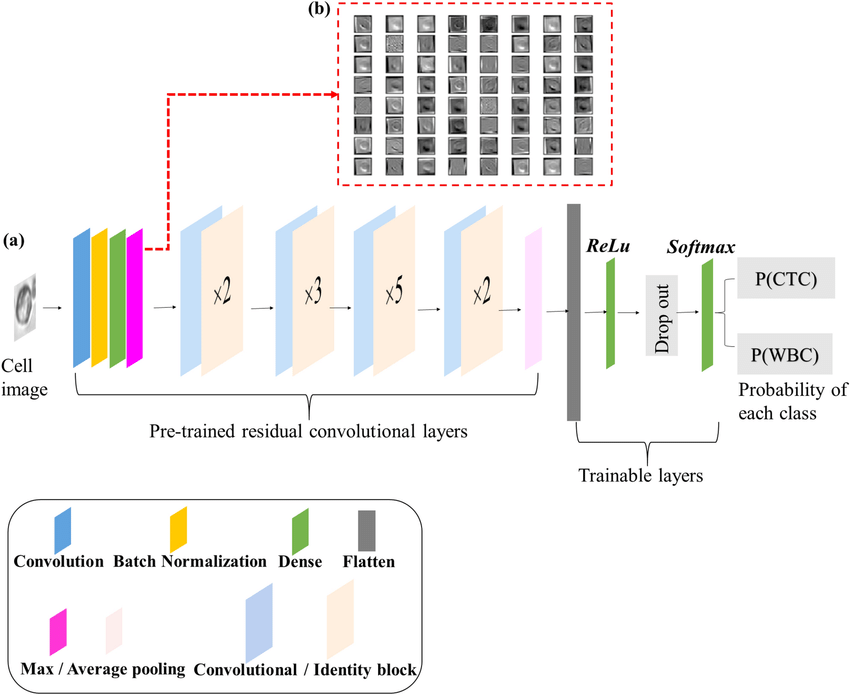

In [ ]:
ResNet50_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=input_shape,
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

ResNet50_model.add(pretrained_model)
ResNet50_model.add(Flatten())
ResNet50_model.add(Dense(256, activation='relu'))
ResNet50_model.add(Dense(4, activation='softmax'))

In [ ]:

ResNet50_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_9 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 256)              524544    
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (None, 4)                1028      
 apper)                                                          
                                                                 
Total params: 24,113,284
Trainable params: 525,572
Non-trainable params: 23,587,712
____________________________________

In [ ]:
ResNet50_model.compile(loss='categorical_crossentropy',optimizer=optimizers.legacy.Adam(learning_rate=.001),  metrics=[metric])


In [ ]:
    # fit
    epochs = 10
    history = ResNet50_model.fit(train_aug, validation_data=val, epochs=epochs, verbose=1)

    print('\n\nTest Results:')
    # evaluate the model on the test data
    ResNet50_model.evaluate(test)

    # plot
    plot_F1_score_loss(history)

    # stops train
    train_ = False

Epoch 1/10
223/223 [==============================] - 32s 128ms/step - loss: 0.4676 - f1_score: 0.8384 - val_loss: 0.2746 - val_f1_score: 0.8405
Epoch 2/10
223/223 [==============================] - 27s 119ms/step - loss: 0.2135 - f1_score: 0.9248 - val_loss: 0.2608 - val_f1_score: 0.8558
Epoch 3/10
223/223 [==============================] - 27s 118ms/step - loss: 0.1650 - f1_score: 0.9436 - val_loss: 0.2420 - val_f1_score: 0.8710
Epoch 4/10
223/223 [==============================] - 27s 119ms/step - loss: 0.1022 - f1_score: 0.9655 - val_loss: 0.2807 - val_f1_score: 0.8686
Epoch 5/10
223/223 [==============================] - 27s 119ms/step - loss: 0.0808 - f1_score: 0.9724 - val_loss: 0.2931 - val_f1_score: 0.8719
Epoch 6/10
223/223 [==============================] - 27s 119ms/step - loss: 0.0599 - f1_score: 0.9818 - val_loss: 0.3166 - val_f1_score: 0.8559
Epoch 7/10
223/223 [==============================] - 27s 120ms/step - loss: 0.0428 - f1_score: 0.9854 - val_loss: 0.2927 - val_f1

In [ ]:
plot_class_f1_score(history.history)

__ResNet50 Results__

__Training__ Loss:  0.0197
__Training__ F1_score: 0.9924
__validation__ loss: 0.3741
__val__ F1_score: 0.8638


__Test__
loss: 0.4047
__Test__
F1_score: 0.8640



__Notes :__
1. The results of ResNet_50 did not outperform the best model available.Especialy that the F1 score for New_Castle_Disease is only 0.68.
2. It is also clear that the model is still suffering from overfiting .Thus the need to add Dropout for example or change the number of neurones in the trainable layers .

### __3.2 EfficientNetB1__



__EfficientNetB1__ is a compact and powerful convolutional neural network (CNN) model that belongs to the EfficientNet family. It is designed to efficiently balance model size and accuracy for various computer vision tasks, such as image classification and object detection. Compared to larger models in the EfficientNet series, EfficientNetB1 offers a reduced computational footprint while still delivering competitive performance. By employing advanced scaling techniques, such as compound scaling and model width/depth/ resolution optimization, EfficientNetB1 achieves a favorable trade-off between model complexity and accuracy. Its smaller size makes it more accessible for resource-constrained environments without sacrificing too much in terms of predictive power, making it a popular choice for applications where efficiency and speed are crucial.

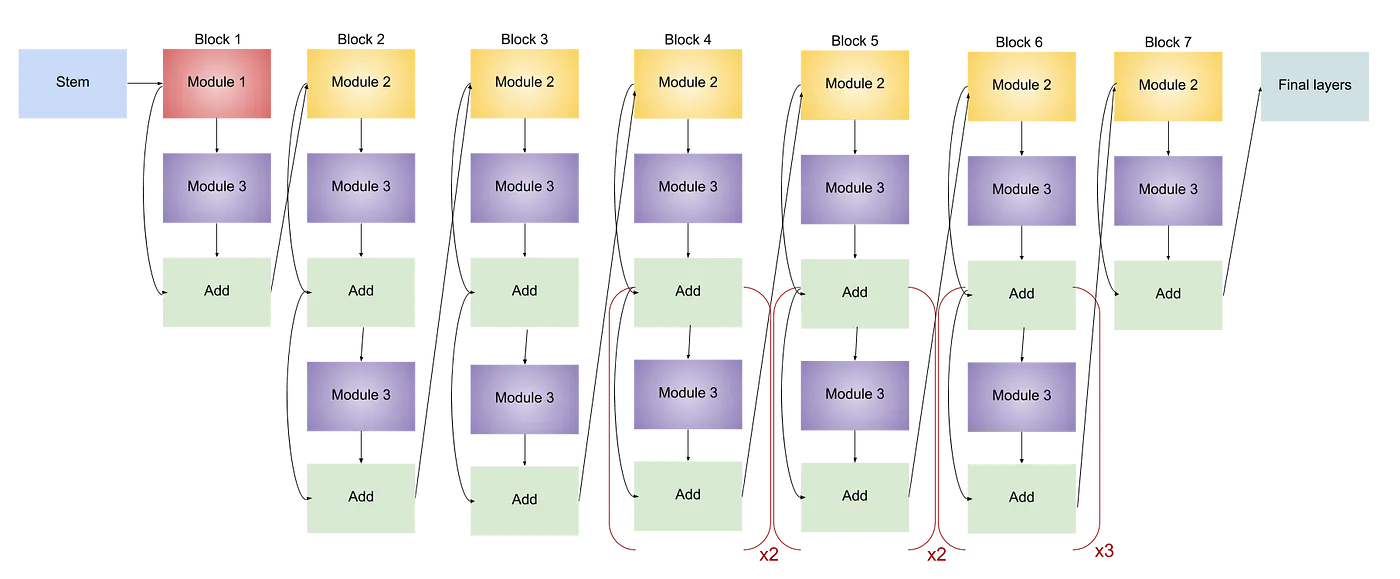

In [ ]:

class CustomDense(Layer):
    def __init__(self, num_classes, activation='softmax', **kwargs):
        super(CustomDense, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.activation = activation

    def build(self, input_shape):
        self.dense = Dense(self.num_classes, activation=self.activation)
        super(CustomDense, self).build(input_shape)

    def call(self, inputs):
        return self.dense(inputs)

input_shape = (224, 224, 3)

effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
effnet_model = effnet.output
effnet_model = GlobalAveragePooling2D()(effnet_model)
effnet_model = CustomDense(4)(effnet_model)
effnet_model = Model(inputs=effnet.input, outputs=effnet_model)

effnet_model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_27[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                           

In [ ]:
effnet_model.compile(loss='categorical_crossentropy',optimizer=optimizers.legacy.Adam(learning_rate=.001),  metrics=[metric])


In [ ]:
    # fit
    epochs = 10
    history = effnet_model.fit(train_aug, validation_data=val, epochs=epochs, verbose=1)

    print('\n\nTest Results:')
    # evaluate the model on the test data
    effnet_model.evaluate(test)

    # plot
    plot_F1_score_loss(history)

    # stops train
    train_ = False

Epoch 1/10
223/223 [==============================] - 105s 406ms/step - loss: 0.2648 - f1_score: 0.8216 - val_loss: 0.4282 - val_f1_score: 0.8422
Epoch 2/10
223/223 [==============================] - 85s 381ms/step - loss: 0.1169 - f1_score: 0.9622 - val_loss: 0.2586 - val_f1_score: 0.8866
Epoch 3/10
223/223 [==============================] - 84s 377ms/step - loss: 0.0922 - f1_score: 0.9687 - val_loss: 0.1902 - val_f1_score: 0.9443
Epoch 4/10
223/223 [==============================] - 87s 390ms/step - loss: 0.0691 - f1_score: 0.9765 - val_loss: 0.3272 - val_f1_score: 0.8940
Epoch 5/10
223/223 [==============================] - 85s 379ms/step - loss: 0.0727 - f1_score: 0.9739 - val_loss: 0.4019 - val_f1_score: 0.8948
Epoch 6/10
223/223 [==============================] - 84s 377ms/step - loss: 0.0486 - f1_score: 0.9832 - val_loss: 0.2631 - val_f1_score: 0.9160
Epoch 7/10
223/223 [==============================] - 84s 377ms/step - loss: 0.0573 - f1_score: 0.9815 - val_loss: 0.1334 - val_f

In [ ]:
plot_class_f1_score(history.history)

__EfficientNetB1__

__Training__ Loss:  0.0537
__Training__ F1_score: 0.9808
__validation__ loss: 0.1454
__val__ F1_score: 0.9574


__Test__
loss: 0.1447
__Test__
F1_score: 0.9603



As predicted the Model using EfficientNetB1 outperformed the other models and gave very satisfying result .It was detecting all classes in a balanced way with and F1 scores  __0.96 , 0.95 , 0.95 and 0.96__ for Coccidiosis,Health,NCD and Salmonella respectively.